In [1]:
import matplotlib.animation as animation
import numpy as np
from pylab import *
from skimage.util import pad

%matplotlib inline
import tensorflow as tf
import os
import json
import subprocess
from scipy.misc import imread

from train import build_lstm_forward, build_overfeat_forward
from utils import googlenet_load, train_utils
from utils.annolist import AnnotationLib as al
from utils.stitch_wrapper import stitch_rects
from utils.train_utils import add_rectangles
import imageio
from skimage.util import pad, crop

In [7]:
filename = 'data/derrick.mp4'
vid = imageio.get_reader(filename, 'ffmpeg')

In [ ]:
images = []
for im in vid:
    #images.append(pad(im,((60,60),(0,0),(0,0)),'constant'))
    print im


[[[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ..., 
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ..., 
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ..., 
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 ..., 
 [[ 8  8  8]
  [ 0  0  0]
  [27 27 27]
  ..., 
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[12 12 12]
  [ 4  4  4]
  [ 0  0  0]
  ..., 
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[11 11 11]
  [17 17 17]
  [ 8  8  8]
  ..., 
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]]
[[[13 13 13]
  [13 13 13]
  [13 13 13]
  ..., 
  [ 2  2  2]
  [ 2  2  2]
  [ 2  2  2]]

 [[13 13 13]
  [13 13 13]
  [13 13 13]
  ..., 
  [ 2  2  2]
  [ 2  2  2]
  [ 2  2  2]]

 [[13 13 13]
  [13 13 13]
  [13 13 13]
  ..., 
  [ 2  2  2]
  [ 2  2  2]
  [ 2  2  2]]

 ..., 
 [[ 8  8  8]
  [ 0  0  0]
  [27 27 27]
  ..., 
  [ 4  2  3]
  [ 4  2  3]
  [ 4  2  3]]

 [[12 12 12]
  [ 4  4  4]
  [ 0  0  0]
  ..., 
  [ 4  2  3]
  [ 4  2  3]
  [ 4  2  3]]

 [[11 11 11]
  [17

In [4]:
dpi = 100

def ani_frame(img):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    im = ax.imshow(img[0],cmap='gray',interpolation='nearest')
    im.set_clim([0,1])
    fig.set_size_inches([5,5])


    tight_layout()


    def update_img(n):
        tmp = img[n]
        im.set_data(tmp)
        return im

    #legend(loc=0)
    ani = animation.FuncAnimation(fig,update_img,len(img),interval=30)
    writer = animation.writers['ffmpeg'](fps=30)

    ani.save('demo.mp4',writer=writer,dpi=dpi)
    return ani

In [7]:
#hypes_file = './hypes/lstm.json'
hypes_file = '../tensorbox/hypes/playertracker.json'

with open(hypes_file, 'r') as f:
    H = json.load(f)
# #true_idl = './data/brainwash/brainwash_val.idl'
# true_idl = './data/playertracker/test.idl'

# pred_idl = './output/val_%s.idl' % os.path.basename(hypes_file).replace('.json', '')
# true_annos = al.parse(true_idl)

0


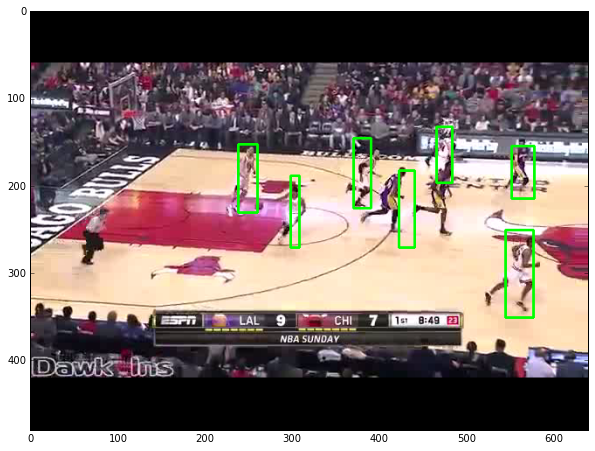

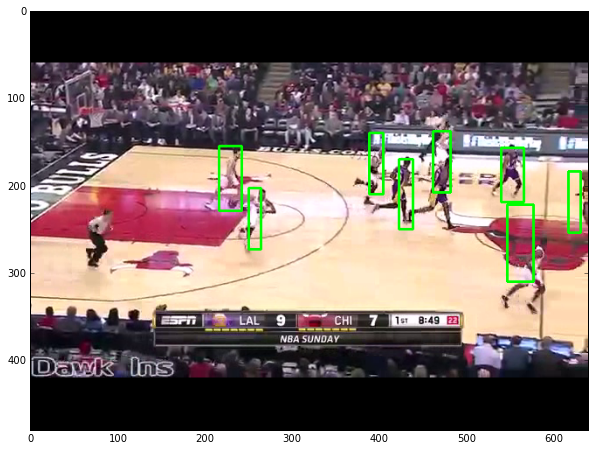

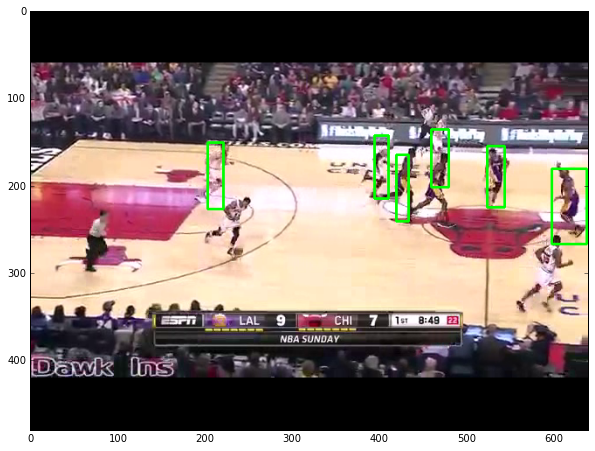

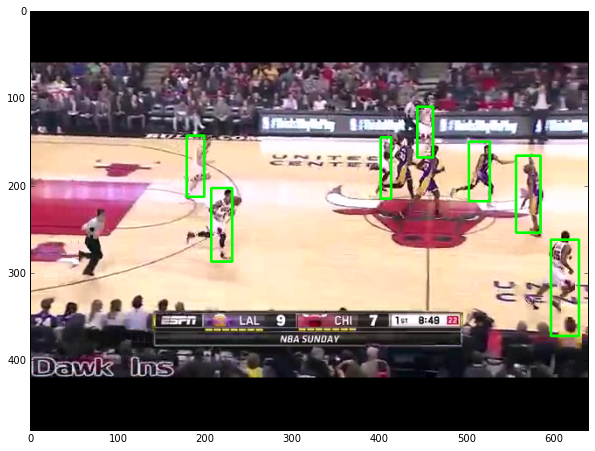

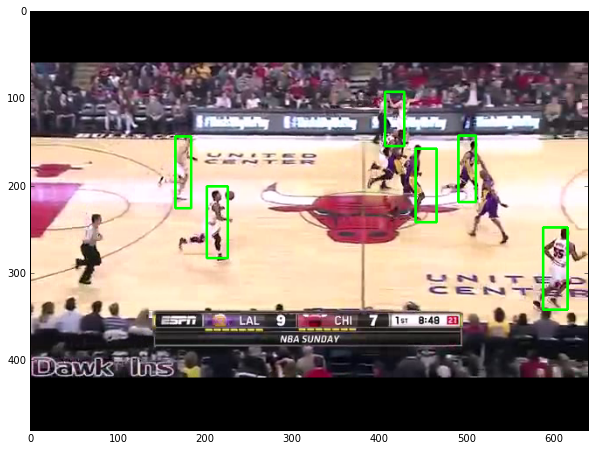

In [9]:
tf.reset_default_graph()
googlenet = googlenet_load.init(H)
x_in = tf.placeholder(tf.float32, name='x_in')
if H['arch']['use_lstm']:
    pred_boxes, pred_logits, pred_confidences = build_lstm_forward(H, tf.expand_dims(x_in, 0), googlenet, 'test', reuse=None)
else:
    pred_boxes, pred_logits, pred_confidences = build_overfeat_forward(H, tf.expand_dims(x_in, 0), googlenet, 'test')
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    if H['arch']['use_lstm']:
        #saver.restore(sess, 'data/lstm/save.ckpt-320000')
        saver.restore(sess, 'output/playertrackerlstm_2016_03_18_19.33/save.ckpt-3000')
    else:
        #saver.restore(sess, 'output/default_2016_02_24_13.25/save.ckpt-69000')
        saver.restore(sess, 'output/playertracker_2016_03_18_14.12/save.ckpt-3000')

    new_images = []
    rectangles = []
    for i in range(0, 65, 1):
        
        #img = imread('./data/brainwash/%s' % true_anno.imageName)
        img = images[i]
        feed = {x_in: img}
        (np_pred_boxes, np_pred_confidences) = sess.run([pred_boxes, pred_confidences], feed_dict=feed)
        new_img, rects = add_rectangles([img], np_pred_confidences, np_pred_boxes,
                                        H["arch"], use_stitching=True, rnn_len=H['arch']['rnn_len'], min_conf=0.3)
        
        new_images.append(new_img)
        rectangles.append(rects)

        if i % 10 == 0 and i < 50:
            fig = plt.figure(figsize=(10, 10))
            plt.imshow(new_img)
        if i % 100 == 0:
            print(i)



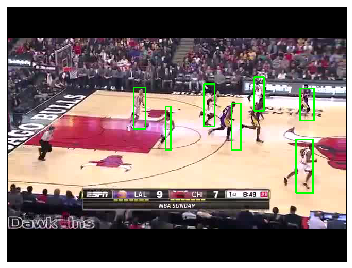

In [10]:
test = ani_frame(new_images)